In [392]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from autoreject import read_auto_reject
from mne import read_epochs, viz
from mne.channels import find_layout, find_ch_adjacency
from pathlib import Path
import matplotlib.pylab as plt
import numpy as np
from mne.decoding import (
    SlidingEstimator, GeneralizingEstimator, Scaler,
    cross_val_multiscore, get_coef
)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import StratifiedKFold
import pandas as pd
%matplotlib notebook

In [117]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar


def many_is_in(multiple, target):
    check_ = []
    for i in multiple:
        check_.append(i in target)
    return any(check_)

In [236]:
epo_path = Path("/home/mszul/datasets/act_mis/MEG/processed/0001/autoreject_zapline_act_mis-0001-ses-001-observation-epo.fif")
ar_path = Path("/home/mszul/datasets/act_mis/MEG/processed/0001/autoreject_zapline_act_mis-0001-ses-001-observation-epo.h5")
beh_path = Path("/home/mszul/datasets/act_mis/BEH/0001/ses2_0001_1553782026.csv")

In [237]:
beh_data = pd.read_csv(beh_path, index_col=[0])
catch_map = ~(beh_data.obs_dir_mod == 0).to_numpy()

In [423]:
beh_data.movement_dir.to_numpy()

array([ 0.46666667, -0.62222222,  0.68888889, -0.5       ,  0.62222222,
        0.52222222,  0.61666667, -0.47222222, -0.54444444,  0.77777778,
        0.72777778, -0.63888889, -0.48888889, -0.55555556,  0.75      ,
        0.65      ,  0.78888889,  0.78888889, -0.67777778,  0.78888889,
        0.51111111,  0.76111111,  0.76111111, -0.66666667, -0.62777778,
       -0.57777778,  0.73333333,  0.76111111,  0.68333333, -0.60555556,
       -0.58333333,  0.66666667,  0.68333333, -0.56666667, -0.61666667,
       -0.58333333, -0.52777778, -0.48888889,  0.72777778,  0.73888889,
       -0.52222222, -0.42222222,  0.8       ,  0.59444444, -0.61111111,
       -0.57222222,  0.69444444,  0.69444444, -0.67222222, -0.45555556,
        0.61666667,  0.60555556,  0.73888889,  0.67222222, -0.7       ,
       -0.66111111,  0.68333333, -0.55555556, -0.57222222,  0.78333333,
        0.79444444,  0.67222222, -0.58888889, -0.57222222, -0.62777778,
        0.42777778,  0.58333333,  0.55      ,  0.58333333, -0.53

In [238]:
epochs = read_epochs(epo_path)
ar = read_auto_reject(ar_path)
reject_log = ar.get_reject_log(epochs)

Reading /home/mszul/datasets/act_mis/MEG/processed/0001/autoreject_zapline_act_mis-0001-ses-001-observation-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated


<IPython.core.display.Javascript object>


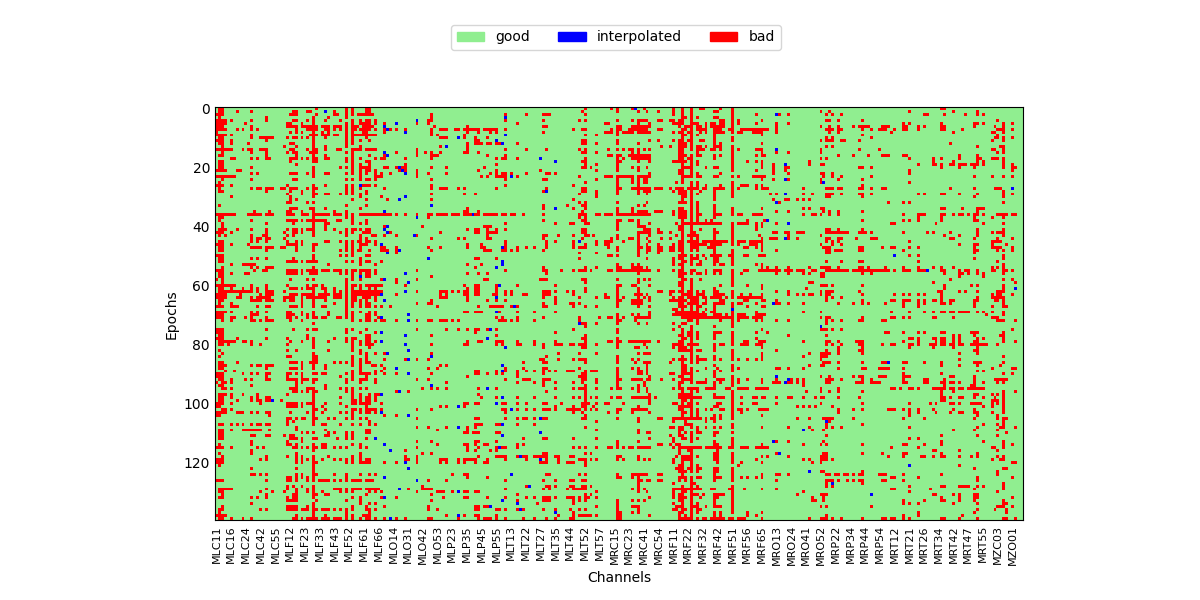

In [239]:
reject_log.plot();

In [240]:
reject_log.bad_epochs.shape

(140,)

<IPython.core.display.Javascript object>


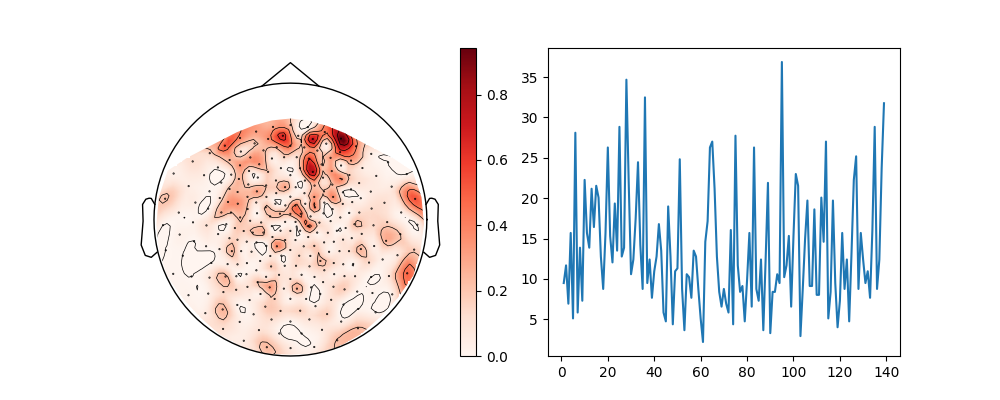

In [241]:

f, ax = plt.subplots(1, 2, figsize=(10,4))

delta = viz.plot_topomap(
    rej_log_labs.mean(axis=0),
    epochs.info,
    sphere=(0,0,0,0.195),
    cmap="Reds",
    axes=ax[0]
)
colorbar(delta[0])

trials_ix = np.arange(rej_log_labs.shape[0])+1
ax[1].plot(trials_ix, rej_log_labs.mean(axis=1)*100)



In [242]:
ch_adj, ch_names = find_ch_adjacency(epochs.info, ch_type="mag")
ch_map = np.array([many_is_in(epochs.info.ch_names, i) for i in ch_names])
ch_adj = ch_adj.toarray()

Reading adjacency matrix for ctf275.


<IPython.core.display.Javascript object>


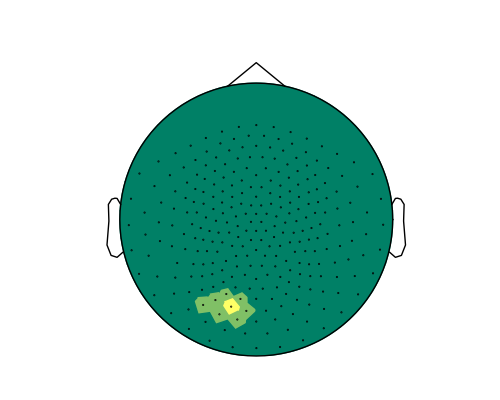

In [437]:
targ_ch = epochs.info.ch_names[62]
targ_adj_ch = np.array(ch_names)[ch_adj[np.array(ch_names) == targ_ch].flatten()]
targ_channel_map = [i == targ_ch for i in epochs.info.ch_names]
adj_channel_map = [many_is_in(targ_adj_ch, i) for i in epochs.info.ch_names]

data = np.zeros(len(epochs.info.ch_names))
data[adj_channel_map] = 0.5
data[targ_channel_map] = 1

f, ax = plt.subplots(1, 1, figsize=(5,4))

delta = viz.plot_topomap(
    data,
    epochs.info,
    sphere=(0,0,0,0.195),
    cmap="summer",
    axes=ax,
    image_interp="nearest",
    contours=0
)

In [410]:
x = epochs.get_data(copy=False)
x = x[:, adj_channel_map,:]
y = (beh_data.obs_dir_mod[catch_map] == -1).to_numpy().astype(int)

class_weight = {
    0: np.sum(y == 0),
    1: np.sum(y == 1)
}

weights = compute_sample_weight(
    "balanced", y
)
fit_kw = {"model__sample_weight": weights}

In [424]:
k_folds = 10
kf = StratifiedKFold(n_splits=k_folds, shuffle=True)
cv_iter = kf.split(np.zeros(x.shape), y)


pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("model", LogisticRegression())
])

sliding_decoder = SlidingEstimator(
    pipeline, n_jobs=1, scoring="roc_auc", verbose=True
)
scores = cross_val_multiscore(sliding_decoder, x, y, cv=cv_iter, fit_params=fit_kw)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/265 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/265 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/265 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/265 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.8s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/265 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/265 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/265 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/265 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/265 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/265 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.4s finished


<IPython.core.display.Javascript object>


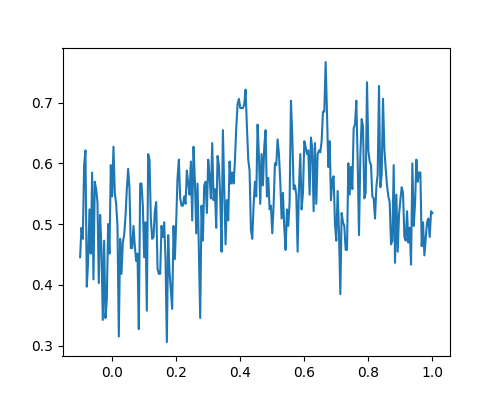

In [425]:
f, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(epochs.times, scores.mean(axis=0))

<IPython.core.display.Javascript object>


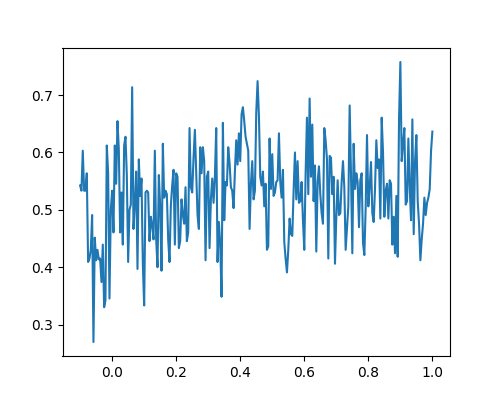

In [363]:
f, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(epochs.times, scores.mean(axis=0))

In [326]:
x[:,:,0].shape

(140, 9)

In [327]:
y

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0])

In [333]:
cv_iter

<generator object _BaseKFold.split at 0x7fc46f82c580>

In [432]:
(epochs.events[:, 2] == 10).astype(int).shape

(140,)